<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"> Lending Club Defaults Exploratory Analysis</h1>

This workbook contains an initial data exploration and engineering of Lending Club data.
Some visualizations are presented and the data is prepared for classification analysis in a second notebook.

[DataSet and Data Dictionary Examination](#data_cell)

[Initial Graphs](#initial_graphs)

[Delete Unwanted Data](#unwanted_data)

[Prepare Data for Analysis](#analysis_prep)


<br><hr>

### Import libraries and load the dataset.



In [43]:

from __future__ import print_function  

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

# Matplotlib for visualization
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")


various helper functions...

In [44]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)


<a id='data_cell'></a>
## 1.  Dataset and Data Dictionary Exploration
To speed up initial analysis I will import a subset of loan data relatomg to 300,000 loans during the period 2016-2018. for the dataset.

In [45]:
# Load excerpt of load stats from CSV
df = pd.read_csv('LendingClub_17_18_excerpt.csv', low_memory=False)


This is the associated data dictionary describing the data features. Below the dictionary is combined with the dataset data types, first row values and information on data completeness. (Note that the data dictionary and dataset are indexed differently and so are joined on the shared feature column.)

In [46]:
data_dictionary = pd.read_excel('LCDataDictionary.xlsx').dropna()
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'feature', 'Description': 'description'})

to_join_df = pd.DataFrame(df.dtypes,columns=['dtypes'])
to_join_df.reset_index(inplace=True)
to_join_df.rename(columns = {'index':'feature'}, inplace = True)
to_join_df["first_row"] = df.loc[0].values
to_join_df["%data_missing"] = (df.isnull().sum()/df.shape[0]*100).values

data_preview = to_join_df.merge(data_dictionary, on ='feature',how ='left')
display_all(data_preview.style.set_properties(subset=['description'], **{'width': '1000px'}))

,feature,dtypes,first_row,%data_missing,description
0,id,object,124036600,0,A unique LC assigned ID for the loan listing.
1,member_id,float64,nan,100,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,14400,0.002,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,14400,0.002,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,14400,0.002,The total amount committed by investors for that loan at that point in time.
5,term,object,60 months,0.002,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,float64,11.99,0.002,Interest Rate on the loan
7,installment,float64,320.25,0.002,The monthly payment owed by the borrower if the loan originates.
8,grade,object,B,0.002,LC assigned loan grade
9,sub_grade,object,B5,0.002,LC assigned loan subgrade


The table above shows that we have 151 columns with a number of columns containing a high percentage of missing data. We will remove some of these near empty columns plus some redundant columns.
These near-empty correspond to loans that have already been charged off and where a debt settlement company is involved. These columns will not add value to our analysis and can be dropped. Deleting/dropping these columns will bring us from 151 to 129 data columns.


In [ ]:
Checking the distribution of loans by year...

In [47]:
df["issue_d"].str.extract('(\d+)').value_counts()

2016    133887
2018    107864
2017     58243
Name: issue_d, dtype: int64

<a id='initial_graphs'></a>

## 2. Initial Data Exploration


By way of intial data exploration the following graphs will be generated: 
  * Loan Status Counts
  * Loan Amounts Distribution
  * Loan Purposes
  * Applicants occupations
  * Interest Rate Distribution
  * Geographical LoanSpread



**Loan status Review **

* Loans that are in "Default" are loans for which borrowers have failed to make payments for an extended period of time.
 
* A loan becomes “Charged Off” when there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off.

* Fully Paid. Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

* Loan is past due but within the 15-day grace period. 

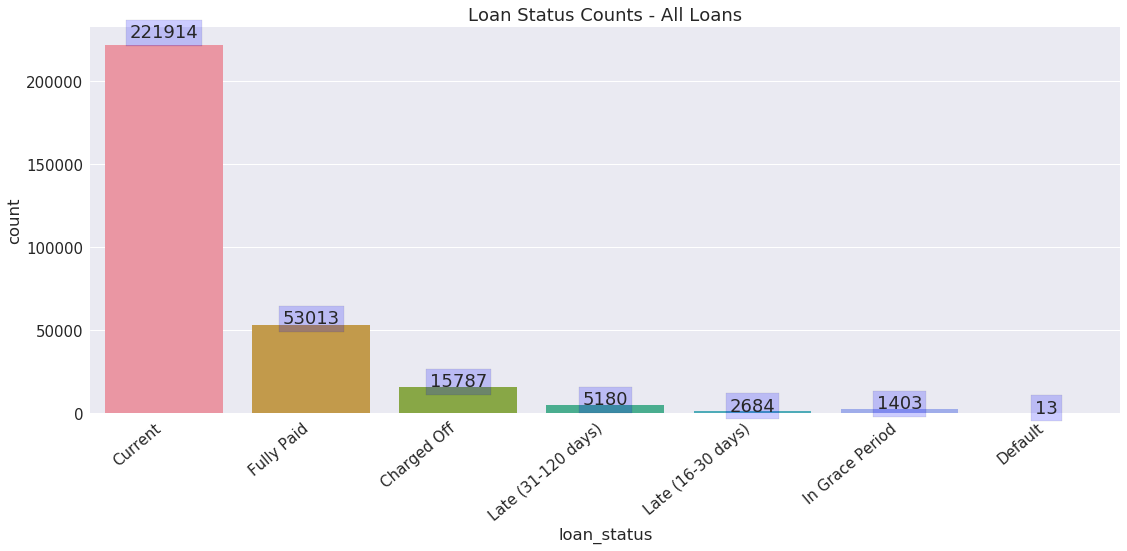

In [48]:
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

ax = sns.countplot(x="loan_status", data=df) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Loan Status Counts - All Loans")

plt.tight_layout()

vals = df["loan_status"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")


In [49]:
df = df.dropna(subset=['loan_amnt'])

Text(0.5,1,'Loan Amounts Distribution')

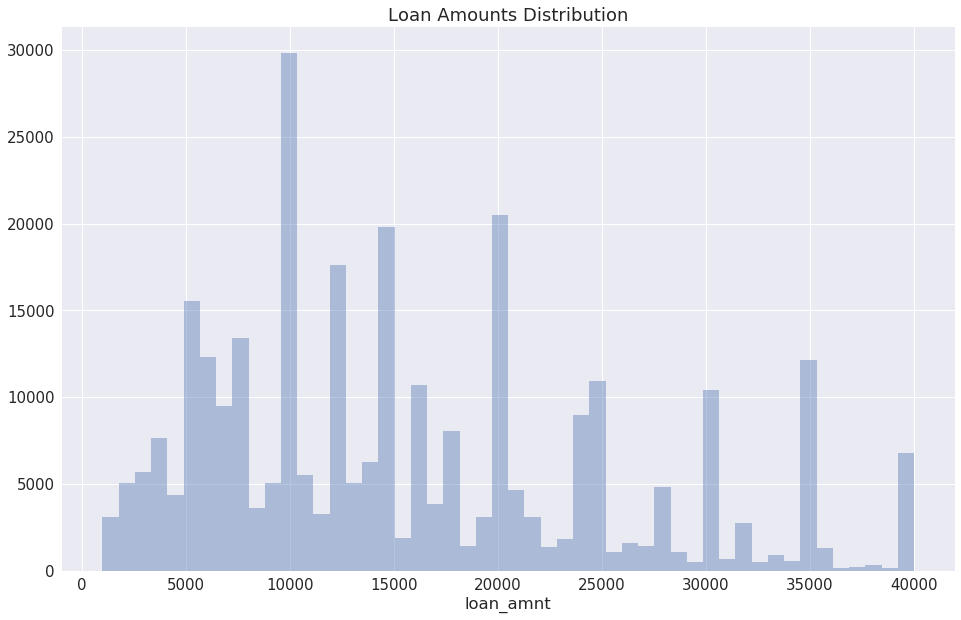

In [50]:
fig= plt.gcf()
fig.set_size_inches( 16, 10)
sns.distplot( a=df["loan_amnt"], hist=True, kde=False, rug=False ).set_title("Loan Amounts Distribution")

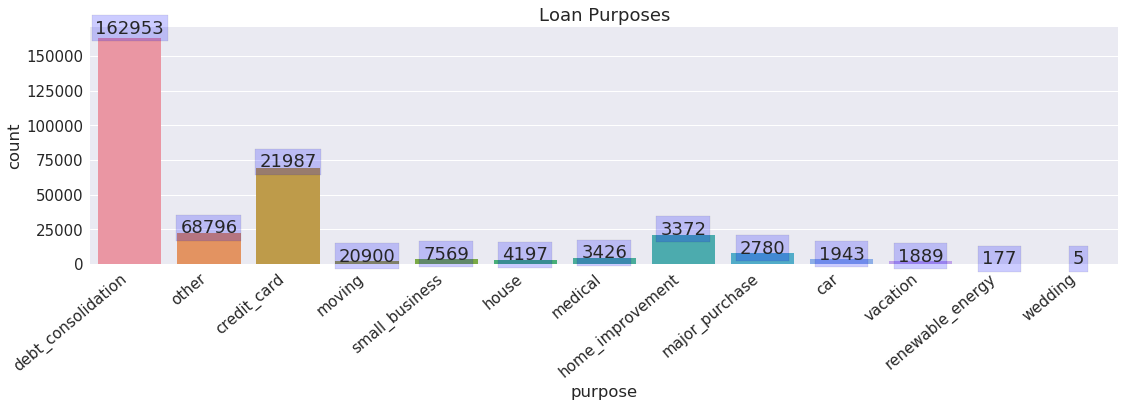

In [51]:

sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches(16, 6)    


ax = sns.countplot(x="purpose", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Loan Purposes")

plt.tight_layout()
#plt.show()

#?ax.text
vals = df["purpose"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")


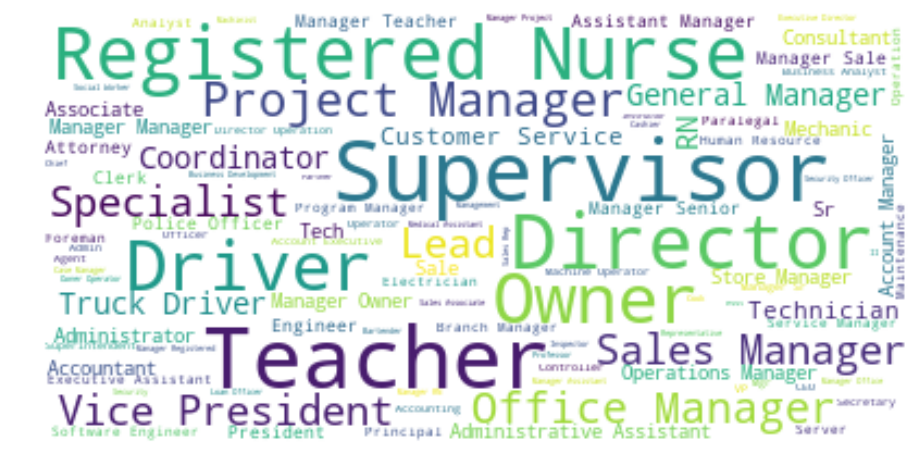

In [52]:
  
text = df["emp_title"].str.cat(sep=' ')
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
plt.figure(figsize=[16,8])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [53]:
df["int_rate"].describe()

count    299994.000000
mean         12.585070
std           4.988808
min           5.310000
25%           9.160000
50%          11.990000
75%          15.310000
max          30.990000
Name: int_rate, dtype: float64

The mean interest rate is c.13% and the rate spread is very large from 5%-31%

Text(0.5,1,'Loan Interest Rate Distribution')

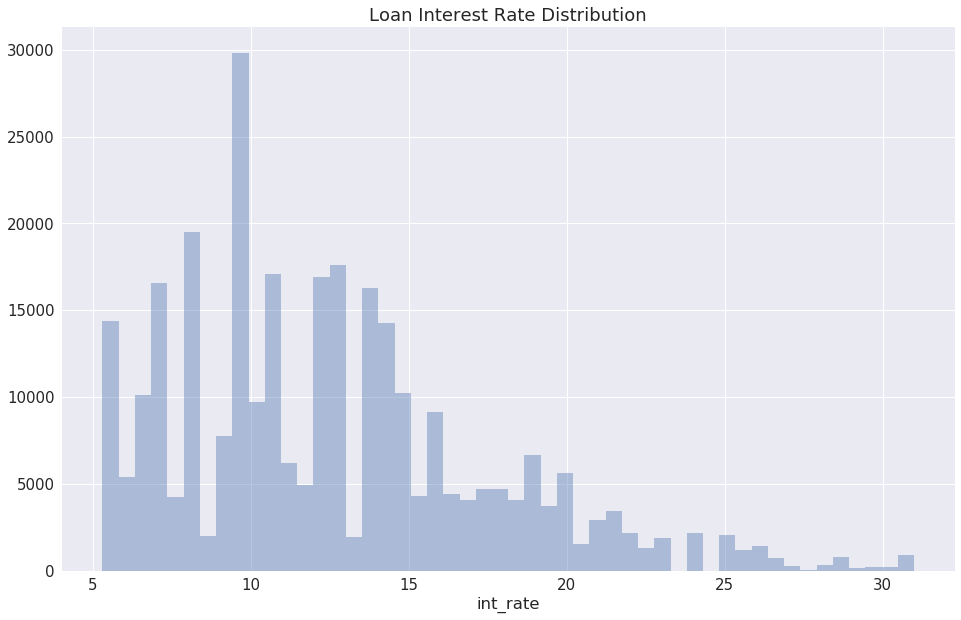

In [54]:
fig= plt.gcf()
fig.set_size_inches( 16, 10)
sns.distplot( a=df["int_rate"], hist=True, kde=False, rug=False ).set_title("Loan Interest Rate Distribution")

<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
[Back to Contents](#toc)
</div>

<a id='analysis_objectives'></a>

<a id='unwanted_data'></a>
## Delete Unwanted Data


Our objective is to predict loan default using only the data we will have at the start of the lending process.
That is, we wish to prevent data leakage influencing our loan performance model.
Accordingly we will remove those features that would not be known when the loan application is being assessed. We also have features with a large amount of missing data. Those features that have more than 50% missing values are deleted. Finally there are features irrelevant to the loan application that are also removed. Note that these 3 classifications are not necessarily disjoint.

LendingClub ues the loan application and credit history of the applicant to assign a grade from A1-E5.
The grade therefore reflects the credit history and we can remove associated features. 
https://www.lendingclub.com/public/rates-and-fees.action
LendingClub also uses Fico Scores which analyse payment history for the applicant.
Finally LendingClub also uses a debt-to-income ratio https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income.
 
It is probably safe to asume that these features subsume many of the credit history features remaining in the dataset. We begin by removing the features below. This reduces the number of features by 50% from the initial dataset for initial analysis.



| Data Leakage | Missing Data > 50% | Irrelevant |
| --- | --- | --- |
| last_pyment_d  |mths_since_last_delinq | url |
| next_pymnt_d| mths_since_last_record | policy_code|
| funded_amnt | mths_since_last_major_derog 	 | id|
| funded_amnt_inv | annual_inc_joint |emp_title|
|issue_d |dti_joint |purpose|
|pymnt_plan|verification_status_joint |desc|
|initial_list_status| mths_since_recent_bc_dlq|title|
|out_prncp|mths_since_recent_revol_delinq| int_rate|
|out_prncp_inv|revol_bal_joint|member_id|
|total_pymnt|sec_app_fico_range_low|acc_now_delinq| 	
|total_pymnt_inv|sec_app_fico_range_high|chargeoff_within_12_mths|
|total_rec_prncp|sec_app_earliest_cr_line |delinq_amnt|
|total_rec_int|sec_app_inq_last_6mths|||
|total_rec_late_fee|sec_app_mort_acc||
|recoveries|sec_app_open_acc|||
|collection_recovery_fee|sec_app_revol_util||
|last_pymnt_d|sec_app_open_act_il|||
|last_pymnt_amnt|sec_app_num_rev_accts|||
|last_credit_pull_d|sec_app_chargeoff_within_12_mths||
|last_fico_range_high|sec_app_mths_since_last_major_derog||
|last_fico_range_low| sec_app_collections_12_mths_ex_med||
|collections_12_mths_ex_med|||
|mths_since_last_major_derog||| 
|num_tl_120dpd_2m |||
|num_tl_30dpd |||
|hardship_flag |||
|hardship_type|||
|hardship_reason|||
|hardship_status|||
|deferral_term |||
|hardship_amount |||
|hardship_start_date |||
|hardship_end_date|||
|payment_plan_start_date |||
|hardship_length |||
|hardship_dpd |||
|hardship_loan_status |||
|hardship_last_payment_amount |||
| orig_projected_additional_accrued_interest |||
| hardship_payoff_balance_amount |||
| debt_settlement_flag |||
| debt_settlement_flag_date |||
| settlement_status |||
| settlement_date |||
| settlement_amount |||
| settlement_percentage |||
| settlement_term |||
| disbursement_method |||


In [55]:
#df = df.drop(['url', 'policy_code', 'last_pymnt_d', 'next_pymnt_d'], axis=1)
#df = df.drop(['funded_amnt', 'funded_amnt_inv', ], axis=1)
data_leakage = ['last_pyment_d','next_pymnt_d', 'funded_amnt', 'funded_amnt_inv', 'issue_d','pymnt_plan', \
               'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', \
               'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', \
               'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', \
               'num_tl_120dpd_2m', 'num_tl_30dpd', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', \
               'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', \
               'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', \
               'hardship_payoff_balance_amount', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', \
               'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term',\
               'hardship_last_payment_amount', 'disbursement_method']

df = df[df.columns.difference(data_leakage)]

missing_data = ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', \
               'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', \
               'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', \
               'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',\
               'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', \
                'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog']

df = df[df.columns.difference(missing_data)]

irrelevant_data = ['url', 'policy_code', 'id', 'emp_title', 'purpose', 'desc', 'title', 'int_rate', 'member_id', 'acc_now_delinq', \
                   'chargeoff_within_12_mths', 'delinq_amnt']
                   
#'acc_now_delinq','acc_open_past_24_mths', 'bc_open_to_buy', 'bc_util', ]

df = df[df.columns.difference(irrelevant_data)]

In [56]:
df.shape

(299994, 72)

The data-set has now been reduced to 72 features, down from 151. The remaining features and some dample values are shown here:

In [18]:
display_all(df.head().T)

,0,1,2,3,4
acc_open_past_24mths,4,1,7,1,4
addr_state,CT,TX,PA,IL,TX
all_util,44,56,50,67,26
annual_inc,73000,100000,44000,77573,105000
application_type,Individual,Individual,Individual,Individual,Individual
avg_cur_bal,11696,12605,20421,3398,4711
bc_open_to_buy,4500,6413,28281,4200,10327
bc_util,82,68.7,31.4,70,54.7
delinq_2yrs,0,0,0,0,1
dti,21.5,11.3,23.49,18.43,6.17


Fico ranges can be calculated in various ways. We will use the average of the 2 fico ranges used by LendingClub.


In [57]:
df["fico_range_avg"] = (df["fico_range_high"] + df["fico_range_low"])/2
df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)


<a id='analysis_prep'></a>
## Prepare Data for Analysis


The objective is to predict which loans are most likely to default.
The target variable will be loan_status. For this analysis we will only consider those loans that have been a) fully paid, b) charged off and c) more than 30 days late in payment. The majority of loans have a status of Current. We will ignore these as they do not help predict non-payment.

In [61]:
df["loan_status"].value_counts()

Current               221914
Fully Paid             53013
Charged Off            15787
Late (31-120 days)      5180
In Grace Period         2684
Late (16-30 days)       1403
Default                   13
Name: loan_status, dtype: int64

In [66]:
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off") | (df["loan_status"] == "Late (31-120 days)")]

In [67]:
loan_status_dict={'Fully Paid':0,'Charged Off':1, 'Late (31-120 days)':1}
loan_status_check = df["loan_status"]
df["loan_status"]=df["loan_status"].apply(loan_status_dict.get)


In [34]:
#df['loan_status'] = pd.get_dummies(df["loan_status"])

In [68]:
loan_status_check.tail(20)

299882    Late (31-120 days)
299884            Fully Paid
299900            Fully Paid
299910            Fully Paid
299911            Fully Paid
299913            Fully Paid
299916            Fully Paid
299920            Fully Paid
299922    Late (31-120 days)
299923           Charged Off
299926            Fully Paid
299929            Fully Paid
299938            Fully Paid
299942           Charged Off
299943    Late (31-120 days)
299953           Charged Off
299954            Fully Paid
299965    Late (31-120 days)
299992            Fully Paid
299997            Fully Paid
Name: loan_status, dtype: object

In [69]:
#df["loan_status"].mean()
df["loan_status"].tail(20)

299882    1
299884    0
299900    0
299910    0
299911    0
299913    0
299916    0
299920    0
299922    1
299923    1
299926    0
299929    0
299938    0
299942    1
299943    1
299953    1
299954    0
299965    1
299992    0
299997    0
Name: loan_status, dtype: int64

In [70]:
df["loan_status"].mean()

0.28341443633414437

### Missing_Values
A number of remaining columns have missing values. As mentioned above most of these columns are
subsumed in the LendingClud credit, dti and Fico scores. Therefore they will be removed - with the exception of emp_length. emp_length may be important and so we will reate an indicator variable to flag it missing where relevant.

In [71]:
display_all(df.isnull().sum()/df.shape[0]*100)  

acc_open_past_24mths           0.000000
addr_state                     0.000000
all_util                       0.044607
annual_inc                     0.000000
application_type               0.000000
avg_cur_bal                    0.005407
bc_open_to_buy                 1.171938
bc_util                        1.234117
delinq_2yrs                    0.000000
dti                            0.062179
earliest_cr_line               0.000000
emp_length                     7.084347
grade                          0.000000
home_ownership                 0.000000
il_util                       13.352257
inq_fi                         0.032441
inq_last_12m                   0.033793
inq_last_6mths                 0.001352
installment                    0.000000
loan_amnt                      0.000000
loan_status                    0.000000
max_bal_bc                     0.032441
mo_sin_old_il_acct             2.557448
mo_sin_old_rev_tl_op           0.000000
mo_sin_rcnt_rev_tl_op          0.000000


In [72]:
df.drop(["bc_open_to_buy", "bc_util", "il_util", "mo_sin_old_il_acct", "mths_since_rcnt_il", "mths_since_recent_bc", \
        "mths_since_recent_inq", "percent_bc_gt_75", "all_util", "avg_cur_bal", "revol_util" ], axis=1, inplace=True)

In [73]:
df = df.dropna(subset=["dti", "inq_fi", "inq_last_12m", "inq_last_6mths", "max_bal_bc", "open_acc_6m", "open_act_il", \
                       "open_il_12m", "open_il_24m", "total_bal_il", "total_cu_tl"])

In [74]:
df = df.dropna(subset=['dti'])

In [75]:
df.shape

(73909, 60)

The following categorical features remain. 

In [76]:
df.select_dtypes(include=["object"]).iloc[0]

addr_state                       TX
application_type         Individual
earliest_cr_line           Oct-2000
emp_length                 < 1 year
grade                             D
home_ownership             MORTGAGE
sub_grade                        D3
term                      36 months
verification_status    Not Verified
zip_code                      780xx
Name: 4, dtype: object

For now we will remove zip_code and addr_state. In future work I might use these to engineer median income and employment features by geographic location if I can source the data.

In [77]:
df.drop(["addr_state", "zip_code"], axis=1, inplace=True)

Scikit-learn cannot process categorical variables so we need ot encode these as numeric.
earliest_cr_line_years and emp_length are straighforward to convert
We also create an indicator variable to flag the c.10% of missing values form emp_length_years

In [78]:
df["earliest_cr_line_years"] = df["earliest_cr_line"].str.extract('(\d+)')
df["earliest_cr_line_years"] = 2018 - pd.to_numeric(df["earliest_cr_line_years"])

In [79]:
df["emp_length_years"] = df["emp_length"].str.extract('(\d+)')
df["emp_length_years"] = pd.to_numeric(df["emp_length_years"])
df["emp_length_years_missing"] = df["emp_length_years"].isnull().astype(int)
df["emp_length_years"].fillna(0, inplace=True)

In [80]:
df.drop(["emp_length", "earliest_cr_line"], axis=1, inplace=True)

We drop sub_grade and focus on the coarser grade feature for initial analysis.
We also transfer term into a numeric variable with unit years

In [81]:
df["term_years"] = df["term"].str.extract('(\d+)')
df["term_years"] = (pd.to_numeric(df["term_years"])/12)

In [82]:
df.drop(["sub_grade", "term"], axis=1,inplace=True)

lets map the grade feature to numeric  values

In [83]:
df["grade"].unique()

array(['D', 'A', 'E', 'C', 'B', 'F', 'G'], dtype=object)

In [84]:
grade_dict={'A':1.,'B':2.,'C':3.,'D':4.,'E':5.,'F':6.,'G':7.,'None':np.nan}
df['grade']=df["grade"].apply(grade_dict.get)


In [85]:
df.select_dtypes(include="object")


,application_type,home_ownership,verification_status
4,Individual,MORTGAGE,Not Verified
17,Individual,MORTGAGE,Not Verified
30,Individual,RENT,Verified
31,Individual,MORTGAGE,Not Verified
43,Individual,MORTGAGE,Not Verified
47,Individual,RENT,Not Verified
49,Individual,OWN,Not Verified
60,Individual,RENT,Source Verified
68,Individual,MORTGAGE,Verified
75,Individual,OWN,Not Verified


3 categorical features remain. These will be turned into indicator variables.

In [86]:
df = pd.get_dummies(df, columns=['application_type', 'home_ownership', 'verification_status'])

In [87]:
df.shape

(73909, 64)

In [88]:
df["loan_status"].mean()

0.28338903245883451

The data has now been cleaned and converted to numeric values. It is now ready for processing to devel a classification model for defaulting loans.  We have reduced the dataset from 151 features to 64 features and from 300,000 loan records to 73,909 loans that have been fully paid or else have been charged off for non-payment and/or are over 31 days delayed in payment.

### Save analytical base table
df.to_csv('lc_analytical_base_table.csv', index=None)